In [1]:


import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_22.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_53.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_37.png
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_69.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_68.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_51.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_75.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_12.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_16.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_72.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_58.jpg
/kaggle/input/dangerous-insects-dataset/farm_insects/Citrus Canker/Image_62.jpg
/kaggle/input/dangerous-insects-dataset/

Found 1591 files belonging to 15 classes.
Using 1273 files for training.
Found 1591 files belonging to 15 classes.
Using 318 files for validation.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 583s 12s/step - accuracy: 0.0801 - loss: 6.3771 - val_accuracy: 0.1006 - val_loss: 5.2088
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 504s 13s/step - accuracy: 0.1392 - loss: 5.6336 - val_accuracy: 0.1635 - val_loss: 4.7789
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 527s 12s/step - accuracy: 0.2392 - loss: 5.0114 - val_accuracy: 0.3113 - val_loss: 4.3742
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 468s 12s/step - accuracy: 0.3407 - loss: 4.5393 - val_accuracy: 0.4969 - val_loss: 4.0188
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 466s 12s/step - accuracy: 0.4242 - loss: 4.2437 - val_accuracy: 0.6541 - val_loss: 3.7161
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 500s 12s/step - accuracy: 0.4936 - loss: 3.9750 - val_accuracy: 0.7327 - 

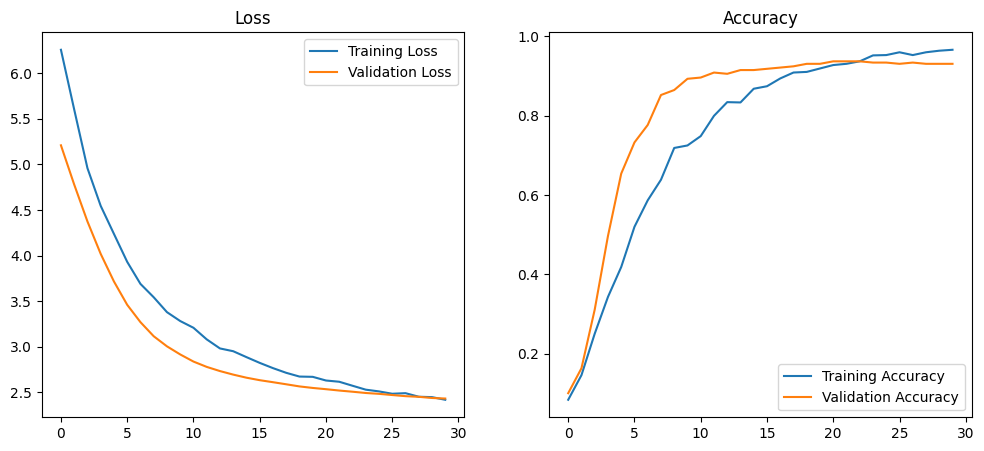

10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step
Test Accuracy: 93.08%


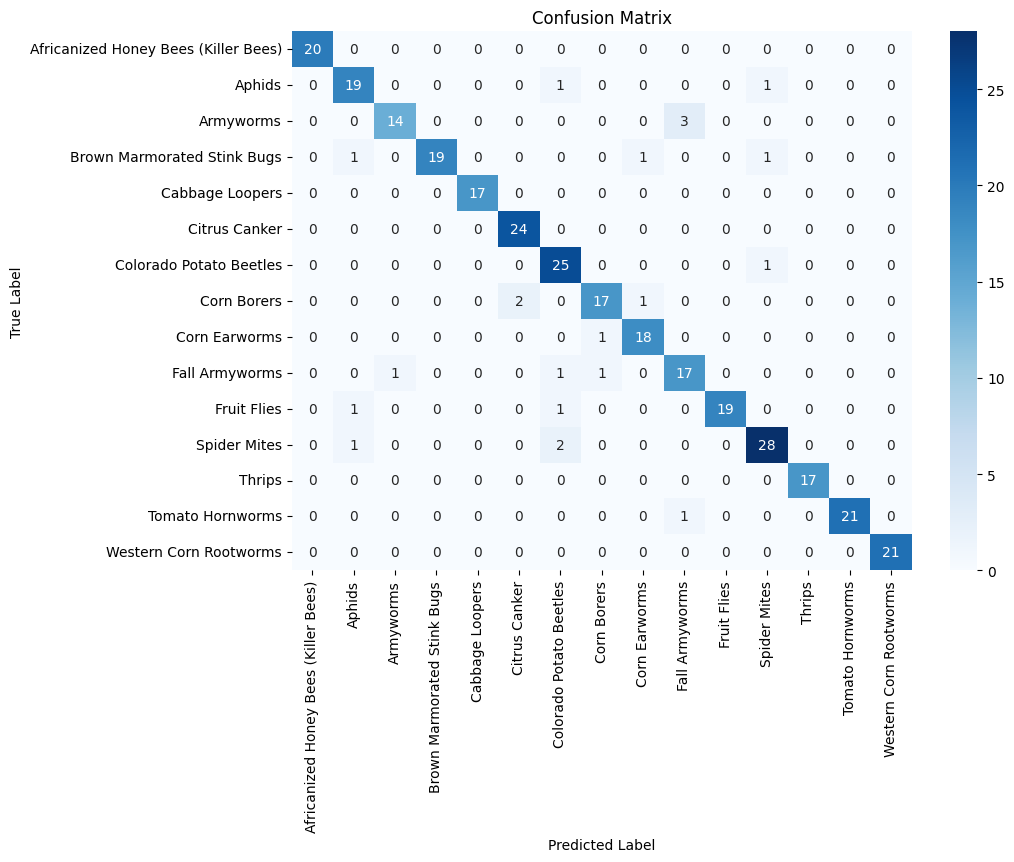

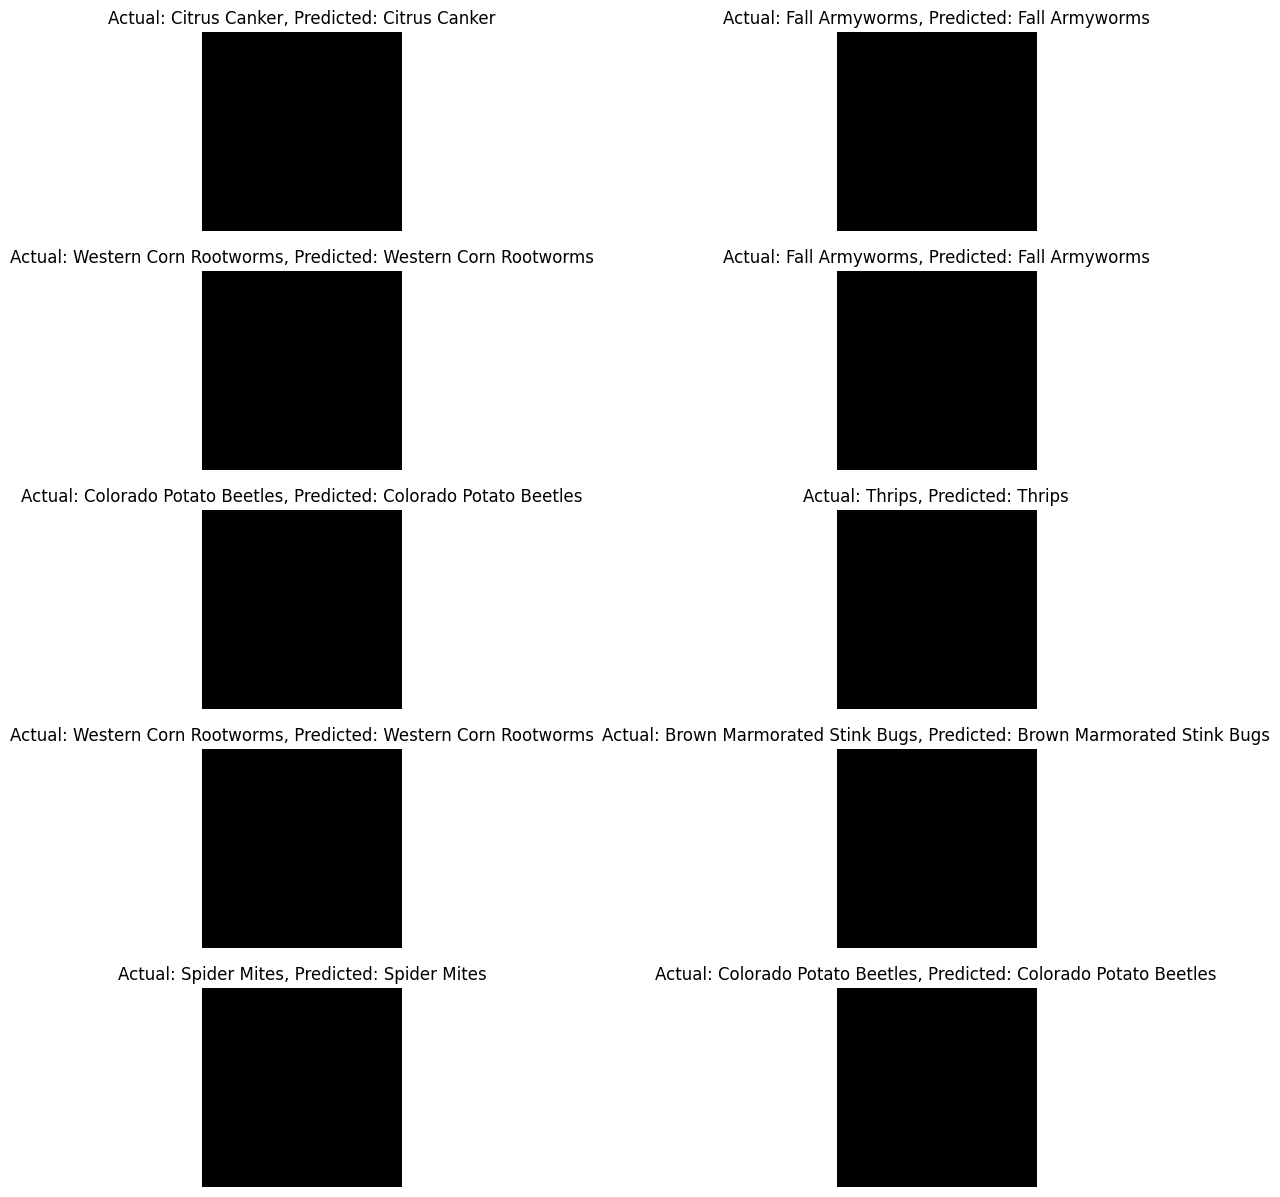

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


image_data = '/kaggle/input/dangerous-insects-dataset/farm_insects' # Update this path to your dataset
batch_size = 32
target_size = (224, 224)
validation_split = 0.2


train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    image_data, validation_split=validation_split, subset="training", seed=100,
    image_size=target_size, batch_size=batch_size)

validation_raw = tf.keras.preprocessing.image_dataset_from_directory(
    image_data, validation_split=validation_split, subset="validation", seed=200,
    image_size=target_size, batch_size=batch_size)


class_names = train_raw.class_names


def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train = train_raw.map(preprocess)
validation = validation_raw.map(preprocess)


def duplicate_inputs(image, label):
    return (image, image), label

train = train.map(duplicate_inputs)
validation = validation.map(duplicate_inputs)


inceptionv3_base = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
densenet_base = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


for layer in inceptionv3_base.layers[:100]:  
    layer.trainable = False
for layer in densenet_base.layers[:100]:
    layer.trainable = False


inceptionv3_output = layers.GlobalAveragePooling2D()(inceptionv3_base.output)
densenet_output = layers.GlobalAveragePooling2D()(densenet_base.output)


concatenated_features = layers.Concatenate()([inceptionv3_output, densenet_output])
x = layers.BatchNormalization()(concatenated_features)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)


hybrid_model = keras.models.Model(inputs=[inceptionv3_base.input, densenet_base.input], outputs=output)
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])


y_train = np.concatenate([y for x, y in train_raw], axis=0)


class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y_train), 
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = hybrid_model.fit(train, epochs=30, validation_data=validation,
                           class_weight=class_weights, callbacks=[early_stopping])


history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


X_val, y_val, y_pred = [], [], []
for (img1, img2), labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(img1.numpy())

predictions = hybrid_model.predict([np.array(X_val), np.array(X_val)])
y_pred = [np.argmax(pred) for pred in predictions]


test_accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


import random
random_indices = random.sample(range(len(X_val)), 10)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(X_val[idx].astype("uint8"))
    actual_label = class_names[y_val[idx]]
    predicted_label = class_names[y_pred[idx]]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
plt.show()


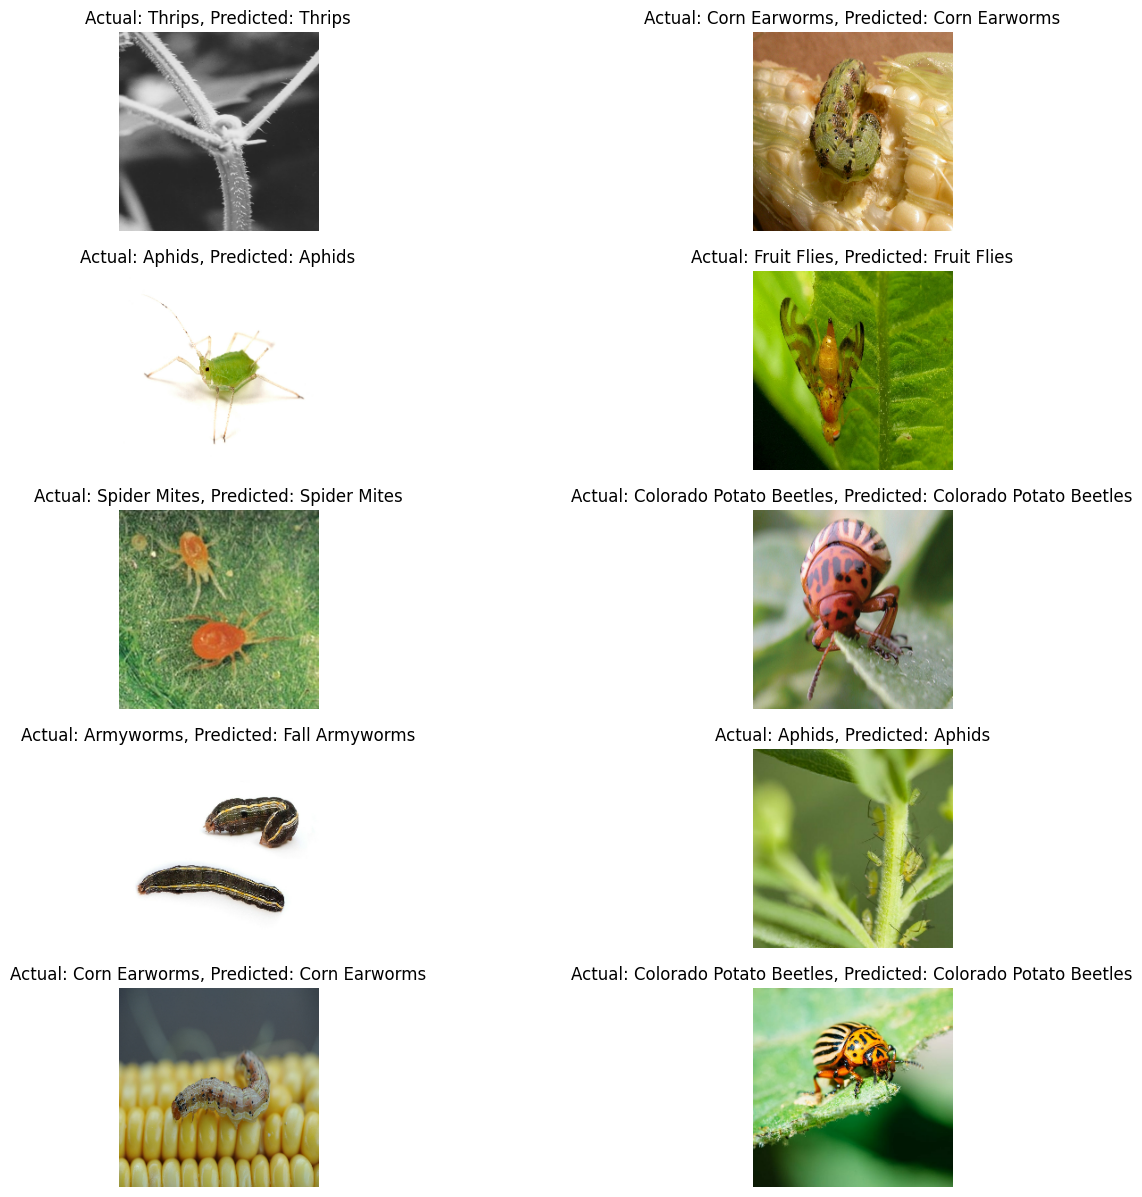

In [2]:
# Display 10 sample images with predicted and actual labels
import random

random_indices = random.sample(range(len(X_val)), 10)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 2, i + 1)
    
    # Multiply image pixel values by 255 to revert normalization
    img = X_val[idx] * 255.0  # Undo the normalization
    
    plt.imshow(img.astype("uint8"))
    actual_label = class_names[y_val[idx]]
    predicted_label = class_names[y_pred[idx]]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
plt.show()
